In [458]:
from __future__ import print_function
import csv
import importlib.util
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
from rdkit.Chem import Crippen
from rdkit.Chem import Lipinski
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import GraphDescriptors
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Descriptors import TPSA
from enum import Enum
import numpy as np
import scipy.stats as stats
import statistics
import math
import seaborn as sns
import string
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import bottchercomplexity as bcf
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 12
plt.rc('text', usetex=True)

In [2]:
#####################
#                   #
# Loading Resources #
#                   #
#####################

In [3]:
cols = ['Barcode','Researcher','Notebook','Page','Smiles','Comments','MW(amu)','MPLOWER','MPUPPER','CardMissing','Notes','LabelNotes']
poster_data = pd.read_csv("MIKI/BurckhalterDatabase.csv", engine='python', names=cols)
new_data = pd.read_csv("BurckhalterDatabase.csv", engine='python', names=cols)
cmld_data = pd.read_csv("MIKI/cmld.csv")

In [4]:
#####################
#                   #
#  Data Interfaces  #
#                   #
#####################

In [555]:
class LibraryError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

class Library:
    def __init__(self, data):
        self.raw_data = data
        self.smiles = self.smilesToList()
        self.molecules = []
        for entry in self.smiles:
            if entry is not None:
                temp = Chem.MolFromSmiles(entry)
                if temp is not None:
                    self.molecules.append(temp)
        self.avgWeight, self.weightstdev, self.molecular_weights = self.getWeightStats()
        self.avgSim, self.fpstdev, self.similarities = self.compareAllFingerprints()
        self.avgCompBertzCT, self.compstdevbertz, self.complexities_bertz = self.getBertzCTComplexityStats()
        # self.avgCompBcf, self.compstdevbcf, self.complexities_bottcher = self.getBottcherComplexityStats()
        self.avgclogp, self.clogpstdev, self.clogps = self.getClogpStats()
        self.avghdonors, self.avghdonors, self.hdonors = self.getHDonorStats()
        self.avghacceptors, self.avghacceptors, self.hacceptors = self.getHAcceptorStats()
        self.avgtopsa, self.stdevtopsa, self.topsas = self.getTopSAStats()
        self.avgsp3, self.stdevsp3, self.sp3hyb = self.getSP3Stats()
        self.avgrings, self.stdevrings, self.rings = self.getRingStats()
        self.avgrotbonds, self.stdevrotb, self.rotbonds = self.getRotBondStats()

    def __filterSmiles():
        return None

    def smilesToList(self):
        smiles_processed = []
        temp = self.raw_data.dropna(subset=['Smiles']).reset_index(drop=True)['Smiles'].to_list()
        # Filter Errors
        for i in temp:
            if ' ' in i.strip(' ') or len(i) == 0: pass
            else: smiles_processed.append(i)
        return smiles_processed

    def compareAllFingerprints(self):
        # The average Tanimoto similarity between any two molecules M and N excluding the
        # similarity between M and M
        fprints = [FingerprintMols.FingerprintMol(x) for x in self.molecules]
        fpcompare = []
        for i in range(0, len(fprints)):
            for j in range(i+1, len(fprints)):
                fpcompare.append(DataStructs.FingerprintSimilarity(fprints[i],fprints[j]))
        tempavgSim = 0
        for i in fpcompare:
            tempavgSim += i
        corrected = []
        for i in fpcompare:
            corrected.append(i*100)
        return (tempavgSim/(len(fprints)-1)), statistics.stdev(corrected), corrected

    def getDescriptor(self, descriptor):
        plist = []
        func = self.getDescriptorFunction(descriptor)
        for i in self.molecules:
            plist.append(func(i))
        avg = statistics.mean(plist)
        stddev = statistics.stdev(plist)
        return avg, stddev, plist


    def getDescriptorFunction(self, descriptor):
        if(descriptor == 'weight'):
            return ExactMolWt
        if(descriptor == 'clogp'):
            return Crippen.MolLogP
        if(descriptor == 'topsa'):
            return TPSA
        if(descriptor == 'rotbonds'):
            return Lipinski.NumRotatableBonds
        if(descriptor == 'fracsp3'):
            return Lipinski.FractionCSP3
        if(descriptor == 'ringcount'):
            return Lipinski.RingCount

    def getTopSAStats(self):
        if(self.topsas is None):
            return self.getDescriptor('topsa')
        else:
            return self.avgtopsa, self.stdevtopsa, self.topsas

    def getSP3Stats(self):
        if(self.sp3hyb is None):
            return self.getDescriptor('fracsp3')
        else:
            return self.avgsp3, self.stdevsp3, self.sp3hyb

    def getRingStats(self):
        if(self.rings is None):
            return self.getDescriptor('ringcount')
        else:
            return self.avgrings, self.stdevrings, self.rings

    def getRotBondStats(self):
        if(self.rotbonds is None):
            return self.getDescriptor('rotbonds')
        else:
            return self.avgrotbonds, self.stdevrotb, self.rotbonds

    def getWeightStats(self):
        if(self.molecular_weights is None):
            molecular_weights = []
            for i in self.molecules:
                molecular_weights.append(self.getDescriptorFunction('weight')(i))
            avg = statistics.mean(molecular_weights)
            stddev = statistics.stdev(molecular_weights)
            return avg, stddev, molecular_weights
        else:
            return self.avgWeight, self.weightstdev, self.molecular_weights

    def getClogpStats(self):
        if(self.clogps is None):
            clogps = []
            for i in self.molecules:
                clogps.append(Crippen.MolLogP(i))
            statistics.mean(clogps)
            stddev = statistics.stdev(clogps)
            return avg, stddev, clogps
        else:
            return self.avgclogp, self.clogpstdev, self.clogps

    def getBottcherComplexityStats(self):
        complexities = []
        for i in self.molecules:
            print(str(i))
            complexities.append(bcf.GetBottcherComplexity(i))
        avg = statistics.mean(complexities)
        stddev = statistics.stdev(complexities)
        return avg, stddev, complexities

    def getBertzCTComplexityStats(self):
        if(self.complexities_bertz is None):
            complexities = []
            for i in self.molecules:
                complexities.append(Chem.GraphDescriptors.BertzCT(i))
            avg = statistics.mean(complexities)
            stddev = statistics.stdev(complexities)
            return avg, stddev, complexities
        else:
            return self.avgCompBertzCT, self.compstdevbertz, self.complexities_bertz

    def getHDonorStats(self):
        if(self.hdonors is None):
            hdonors = []
            for i in self.molecules:
                hdonors.append(Lipinski.NumHDonors(i))
            avg = statistics.mean(hdonors)
            stddev = statistics.stdev(hdonors)
            return avg, stddev, hdonors
        else:
            return self.avghdonors, self.hdonorstdev, self.hdonors

    def getHAcceptorStats(self):
        if(self.hacceptors is None):
            hacceptors = []
            for i in self.molecules:
                hacceptors.append(Lipinski.NumHAcceptors(i))
            avg = statistics.mean(hacceptors)
            stddev = statistics.stdev(hacceptors)
            return avg, stddev, hacceptors
        else:
            return self.avghacceptors, self.hacceptorstdev, self.hacceptors

    def __repr__(self):
        return "Library"


    raw_data = None

    # Postprocessed Data
    smiles = None
    molecules = None

    # Statistics
    topsas = None
    avgtopsa = None
    stdevtopsa = None

    sp3hyb = None
    avgsp3 = None
    stdevsp3 = None

    rings = None
    avgrings = None
    stdevrings = None

    rotbonds = None
    avgrotbonds = None
    stdevrotb = None

    hdonors = None
    avghdonors = None
    hdonorstdev = None

    hacceptors = None
    avghacceptors = None
    hacceptorstdev = None

    similarities = None
    avgSim = None
    fpstdev = None

    complexities_bertz = None
    avgCompBertzCT = None
    compstdevbertz = None

    complexities_bottcher = None
    avgCompBcf = None
    compstdevbcf = None

    molecular_weights = None
    avgWeight = None
    weightstdev = None

    clogps = None
    avgclogp = None
    clogpstdev = None


In [ ]:
class BurckData:
    def __init__(self, poster_data, new_data, cmld_data):

        if(isinstance(poster_data, Library)):
            self.poster_lib = poster_data
        else:
            self.poster_lib = Library(poster_data)
        if(isinstance(new_data, Library)):
            self.new_lib = new_data
        else:
            self.new_lib = Library(new_data)
        if(isinstance(cmld_data, Library)):
            self.cmld_lib = cmld_data
        else:
            self.cmld_lib = Library(cmld_data)

    def fmtTitle(self, titlestr, liblbl, nummols):
            title = titlestr + " in "
            if liblbl == 'MIKI':
                title = title + " the "
            else:
                title = title + " a "
            title = title + str(nummols) + "-Member " + liblbl + " Subset"
            return title

    def getLib(self, lib):
        if lib == 'poster':
            return self.poster_lib, "MIKI"
        elif lib == 'burck':
            return self.new_lib, "BHC"
        elif lib == 'cmld':
            return self.cmld_lib, "CMLDC"
        else:
            raise LibraryError("Could not find library.")

    def getSmiles(self, lib):
        try:
            temp = self.getLib(lib).smiles
            return temp
        except LibraryError:
            print("Got it!")

    def getMolecules(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return temp
        except LibraryError:
            print("Got it!")

    def getNumSmiles(self, lib):
        try:
            temp = self.getLib(lib).smiles
            return len(temp)
        except LibraryError:
            print("Aborting...")

    def getNumMolecules(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return len(temp)
        except LibraryError:
            print("Aborting...")

    def validatedMolToCsv(self, lib):
        """Return a CSV representation of every molecule in the library if and only if RDKIT
        was able to process it."""
        pass

    def getFunction(self, lib, param):
        if(param == 'weight'):
            return lib.getWeightStats()
        elif(param == 'hacceptors'):
            return lib.getHAcceptorStats()
        elif(param == 'hdonors'):
            return lib.getHDonorStats()
        elif(param == 'clogps'):
            return lib.getClogpStats()
        elif(param == 'bertzct'):
            return lib.getBertzCTComplexityStats()
        elif(param == 'rotbonds'):
            return lib.getRotBondStats()
        elif(param == 'fracsp3'):
            return lib.getSP3Stats()
        elif(param == 'polar_sa'):
            return lib.getTopSAStats()
        elif(param == 'rings'):
            return lib.getRingStats()
        else:
            return None

    def __formatAxes(self, ax, gtype, maxval, param, **kwargs):
        if(kwargs['inc_title'] if 'inc_title' in kwargs else False):
            ax.set_title(self.fmtTitle(kwargs['title'] if 'title' in kwargs else "MISSING TITLE", liblbl, len(param)))
        if param == 'hacceptors' or param == 'hdonors':
            xrange = np.arange(0, math.ceil(maxval)+1, 1)
            ax.set_xticks(xrange)
        ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else "MISSING XLABEL")
        if(gtype == 'boxplot'):
            ax.set_yticklabels([kwargs['ylabel']], rotation=45)
        else:
            ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else "MISSING YLABEL")

    def __getHistogram(self, lib, param, ax, **kwargs):
        temp, liblbl = self.getLib(lib)
        avg, stdev, param = self.getFunction(temp, param)
        ax.hist(param, histtype='barstacked',
                bins= kwargs['bins'] if 'bins' in kwargs else int(max(param)) if int(max(param)) < 50 else 50,
                density = kwargs['density'] if 'density' in kwargs else True,
                alpha = float(kwargs['alpha']) if 'alpha' in kwargs else 1,
                label=liblbl,
                align='mid')
        self.__formatAxes(ax, 'histogram', max(param), param, **kwargs)

    def __getBoxplot(self, lib, param, ax, **kwargs):
        temp, liblbl = self.getLib(lib)
        avg, stdev, values = self.getFunction(temp, param)
        ax.boxplot(values,
                   vert=kwargs['vert'] if 'vert' in kwargs else False,
                   showfliers=kwargs['showfliers'] if 'showfliers' in kwargs else False)

        if(kwargs['mask_outliers'] if 'mask_outliers' in kwargs else True):
            upper_quartile = np.percentile(values, 75) + (kwargs['mask_offset'] if 'mask_offset' in kwargs else 1)
            outlier_mask = [value for value in values if value > upper_quartile]
            x = np.random.normal(1, 0.04, size=len(outlier_mask))
            ax.scatter(outlier_mask, x, alpha=0.2)
        self.__formatAxes(ax, 'boxplot', param, max(values), ylabel=liblbl, xlabel=None, **kwargs)

    def __getDistribution(self, lib, param, ax, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, values = self.getFunction(temp, param)
            temp.getFingerprintSimilarityAverage()
            x_axis = np.arange(kwargs['dist_xmin'] if 'dist_xmin' in kwargs else -10,
                               kwargs['dist_xmax'] if 'dist_xmax' in kwargs else 100,
                               kwargs['dist_jump'] if 'dist_jump' in kwargs else 1)
            ax.plot(x_axis, stats.norm.pdf(x_axis, avg*100, stdev))
            if 'title' in kwargs:
                ax.set_title(self.fmtTitle(kwargs['title'] if 'title' in kwargs else "MISSING TITLE", liblbl, len(param)))
            plt.title(self.fmtTitle("Similarity Between Molecule 1 and Others", liblbl, len(temp.molecules)))
            plt.xlabel("Similarity Score")
            plt.ylabel("Fraction of Molecules with Score")
            if path is not None:
                plt.savefig(path)
        except LibraryError:
            pass

    def getPlot(self, gtype, lib, param, ax, **kwargs):
        try:
            if(isinstance(lib, list)):
                for entry in lib:
                    if(gtype == 'histogram'):
                        self.__getHistogram(entry, param, ax, **kwargs)
                    if(gtype == 'boxplot'):
                        self.__getBoxplot(entry, param, ax, **kwargs)
                    if(gtype == 'distribution'):
                        self.__getDistribution(entry, param, ax, **kwargs)
            else:
                if(gtype == 'histogram'):
                    self.__getHistogram(lib, param, ax, **kwargs)
                if(gtype == 'boxplot'):
                    self.__getBoxplot(lib, param, ax, **kwargs)
                if(gtype == 'distribution'):
                    self.__getDistribution(lib, param, ax, **kwargs)
        except LibraryError:
            pass

    def getSimilarityDistribution(self, lib, path=None):
        try:
            temp, liblbl = self.getLib(lib)
            temp.getFingerprintSimilarityAverage()
            title = "Similarity Between Molecule 1 and Others in "
            plt.title(self.fmtTitle("Similarity Between Molecule 1 and Others", liblbl, len(temp.molecules)))
            plt.xlabel("Similarity Score")
            plt.ylabel("Fraction of Molecules with Score")
            if path is not None:
                plt.savefig(path)
        except LibraryError:
            pass

    def getComplexityDistribution(self, lib, path=None):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, complexities = temp.getComplexityStats()
            x_axis = np.arange(-1000, 3000, 1)
            fig = plt.figure()
            plt.plot(x_axis, stats.norm.pdf(x_axis, avg, stdev))
            plt.title(self.fmtTitle("Complexity Distribution of Molecules", liblbl, len(complexities)))
            plt.xlabel("Complexity")
            plt.ylabel("Fraction of Molecules with Score")
            if path is not None:
                plt.savefig(path)
        except LibraryError:
            pass

    def getClogPDistribution(self, lib, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, clogps = temp.getClogPStats()
            x_axis = np.arange(-10, 20, 1)
            fig = plt.figure()
            plt.plot(x_axis, stats.norm.pdf(x_axis, avg, stdev))
            plt.title(self.fmtTitle("CLogP values of Molecules", liblbl, len(clogps)))
            plt.xlabel("clogp")
            plt.ylabel("Fraction of Molecules with Score")
            if path in kwargs:
                plt.savefig(path)
        except LibraryError:
            pass

    # Libraries
    poster_lib = None
    new_lib = None
    cmld_lib = None


In [7]:
class PIDGINData:
    def __init__(self, data, cmdline_output):
        self.raw_data_file = data
        self.cmdline_out = cmdline_output
        self.rejected_smiles = []
        self.rejected_smiles_indices = []
        results = []
        with open(data, 'r') as f:
            for line in f:
                results.append(line)
        for index, line in enumerate(results):
            results[index] = line.replace('\n', '').split('\t')
        temp = pd.DataFrame(results)
        self.processed_data = temp.rename(columns=temp.iloc[0]).drop(temp.index[0]).reset_index(drop=True)
        self.total_processed = 0
        with open(cmdline_output, 'r') as f:
            for line in f:
                tokenized_line = line.split(' ')
                if (len(tokenized_line) > 1) and (tokenized_line[1] == 'SMILES'):
                    self.rejected_smiles_indices.append(tokenized_line[-5])
                    self.rejected_smiles.append(tokenized_line[-1])
                if (len(tokenized_line) > 1) and (tokenized_line[1] == 'Processing'):
                    self.total_processed = tokenized_line[-1].strip('\n')
        self.processed_data = self.processed_data.replace('nan', np.NaN)

    def getActivityByName(self, mol_name, threshold = 0.0):
        try:
            rows = self.processed_data[mol_name].dropna().index.tolist()
            this_drug = self.processed_data.iloc[rows]
            metadata = this_drug.loc[:,'Uniprot':'Model_ID'].copy(deep=True)
            metadata[mol_name] = this_drug[mol_name]
            return metadata
        except KeyError:
            print("Molecule " + mol_name + " not found. It was probably rejected by PIDGIN.")
            return None

    raw_data_file = None
    processed_data = 0
    cmdline_out = None
    rejected_smiles = None
    rejected_smiles_indices = None
    total_processed = None


In [ ]:
##########################################
#                                        #
# Compound Collection Figures Start Here #
#                                        #
##########################################

In [551]:
poster = Library(poster_data)

In [553]:
burck = Library(new_data)
cmld = Library(cmld_data)

In [554]:
libraries = BurckData(poster, burck, cmld)

In [580]:
def generatePaperFigure(libs, param, **kwargs):
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.5
    offset_burck = kwargs['mask_offset'] if 'mask_offset' in kwargs else 1
    offset_cmld = kwargs['mask_offset_cmld'] if 'mask_offset_cmld' in kwargs else offset_burck
    fig, axs = plt.subplots(4,1,figsize=(10,12), sharex=True)
    axs[0].xaxis.set_tick_params(which='both', labelbottom='True')
    axs[1].xaxis.set_tick_params(which='both', labelbottom='True')
    gs = axs[1].get_gridspec()
    for ax in axs[2:]:
        ax.remove()
    axbig = fig.add_subplot(gs[2:])
    plt.suptitle(kwargs['title'] if 'title' in kwargs else "MISSING TITLE", x=0.5, y=0.9)
    libraries.getPlot('boxplot', libs[0], param, axs[0], mask_offset=offset_burck)
    libraries.getPlot('boxplot', libs[1], param, axs[1], mask_offset=offset_cmld)
    libraries.getPlot('histogram', libs, param, axbig,
                      alpha=alpha,
                      **kwargs)
    axbig.legend()

In [279]:
def generateDistributionFigure(libs, param, **kwargs):
    x_label = kwargs['xlabel'] if 'xlabel' in kwargs else "MISSING XLABEL"
    y_label = kwargs['ylabel'] if 'ylabel' in kwargs else "MISSING YLABEL"
    fig, axs = plt.subplots(1,1,figsize=(12,10), sharex=True)
    plt.suptitle(kwargs['title'] if 'title' in kwargs else "MISSING TITLE", x=0.5, y=0.9)
    libraries.getPlot('distribution', libs[0], param, axs)
    axs.legend()

In [ ]:

generateDistributionFigure(['burck'], 'clogps',
                           title="Distribution of Tanimoto Similariy Scores in Two Collections",
                           ylabel="Probability A Pair Will Have Some Score",
                           xlabel="Similarity Score")

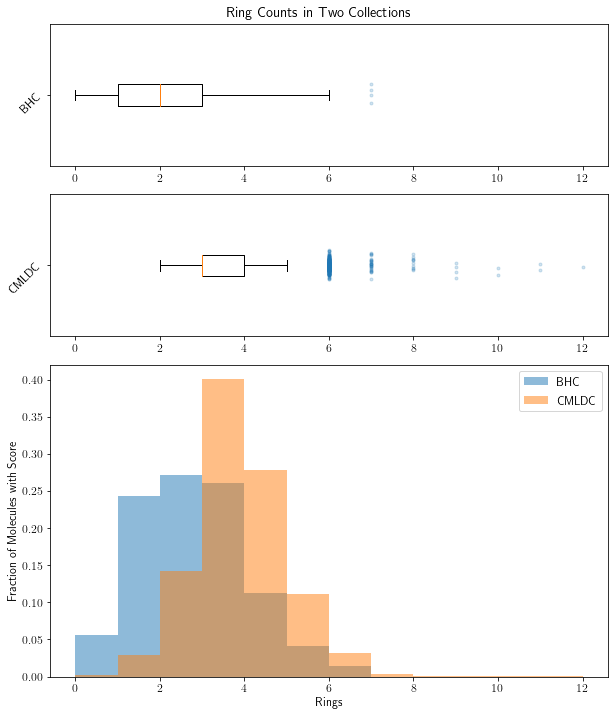

In [595]:
# Ring Count
generatePaperFigure(['burck', 'cmld'],
                    'rings',
                    title="Ring Counts in Two Collections",
                    mask_offset=3,
                    mask_offset_cmld=1,
                    xlabel="Rings",
                    ylabel="Fraction of Molecules with Score",
                    )
plt.savefig("ringcounts.png")

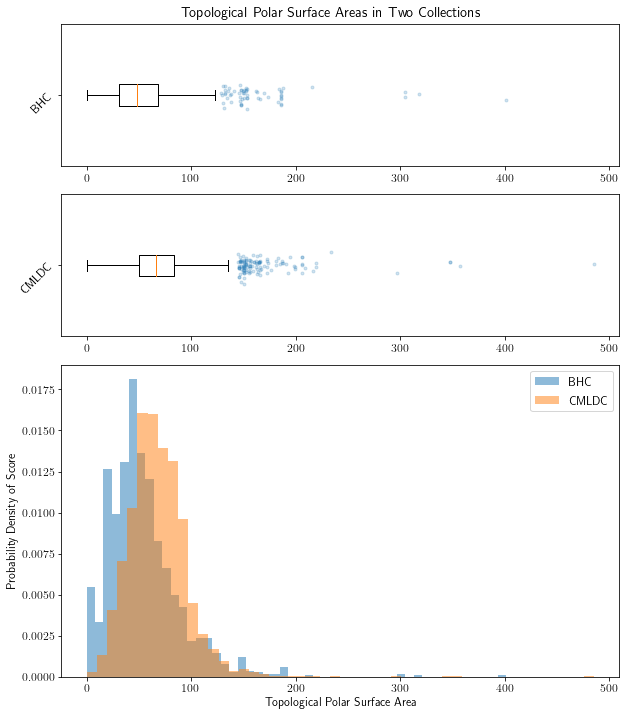

In [587]:
# Polar Surface Area
generatePaperFigure(['burck', 'cmld'],
                    'polar_sa',
                    title="Topological Polar Surface Areas in Two Collections",
                    mask_offset=60,
                    xlabel="Topological Polar Surface Area",
                    ylabel="Probability Density of Score"
                    )
# plt.savefig("tpsa.png")

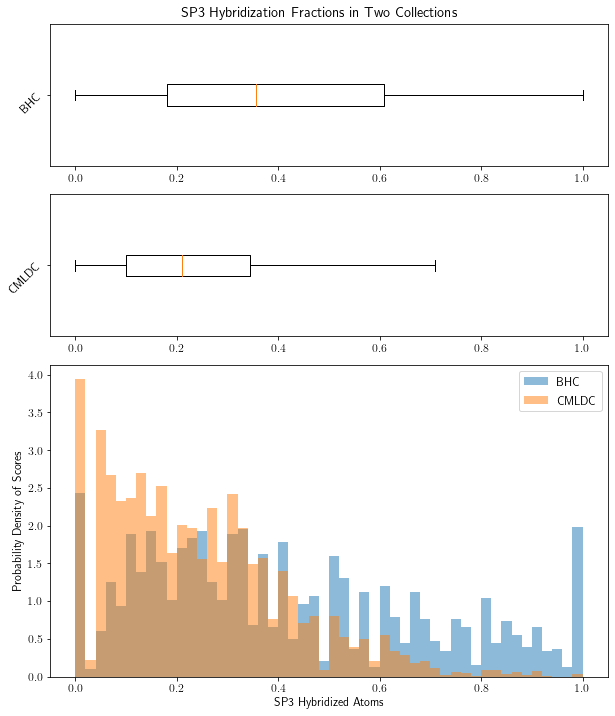

In [568]:
# Fraction SP3 Atoms
generatePaperFigure(['burck', 'cmld'],
                    'fracsp3',
                    title="SP3 Hybridization Fractions in Two Collections",
                    mask_offset=4,
                    xlabel="SP3 Hybridized Atoms",
                    ylabel="Probability Density of Scores",
                    bins=50
                    )

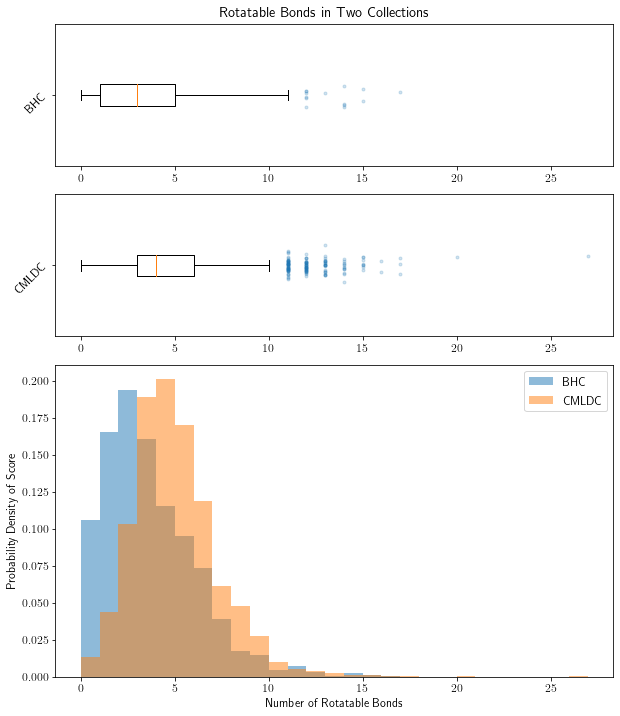

In [578]:
# Fraction Rotatable Bonds
generatePaperFigure(['burck', 'cmld'],
                    'rotbonds',
                    title="Rotatable Bonds in Two Collections",
                    mask_offset=6,
                    mask_offset_cmld=4,
                    xlabel="Number of Rotatable Bonds",
                    ylabel="Probability Density of Score"
                    )

In [ ]:
# ClogPs
generatePaperFigure(['burck', 'cmld'],
                    'clogps',
                    title="CLogP Values in Two Collections",
                    mask_offset=4,
                    xlabel="CLogP Value",
                    ylabel="Fraction of Molecules with Score",
                    bins=50
                    )

In [ ]:
# H Donors
generatePaperFigure(['burck', 'cmld'], 'hdonors',
                    title="Number of Hydrogen-Bond Donors in Two Collections",
                    xlabel="Number of H-Bond Donors",
                    ylabel="Fraction of Molecules with Score",
                    bins=50
                    )


In [ ]:
# H Acceptors
generatePaperFigure(['burck', 'cmld'], 'hacceptors',
                    title="Number of Hydrogen-Bond Acceptors in Two Collections",
                    mask_offset = 3,
                    xlabel="Number of H=Bond Acceptors",
                    ylabel="Fraction of Molecules with Score",
                    bins=50)


In [ ]:
# Weight
generatePaperFigure(['burck', 'cmld'], 'weight',
                    title="Molecular Weight in Two Collections",
                    mask_offset = 200,
                    xlabel="Molecular Weight",
                    ylabel="Fraction of Molecules with Molecular Weight")

In [ ]:
# Complexity, BertzCT
generatePaperFigure(['burck', 'cmld'], 'bertzct',
                    title="BertzCT Complexity Scores in Two Collections",
                    mask_offset = 650,
                    xlabel="Complexity (BertzCT)",
                    ylabel="Fraction of Molecules with Score")

In [ ]:
tpconf = pd.read_csv("target_prediction_confidence.csv")
fda = tpconf.loc[tpconf['Collection'] == 'FDA']
bhc = tpconf.loc[tpconf['Collection'] == 'BHC']
cmld = tpconf.loc[tpconf['Collection'] == 'CMLD']
fig, ax = plt.subplots(figsize=(10,7))
plt.title("Target Prediction Confidence")
plt.scatter(s=27, x=cmld['confidence'], y=cmld['value'], label='CMLDC')
plt.scatter(s=27, x=fda['confidence'], y=fda['value'], label='FDA')
plt.scatter(s=27, x=bhc['confidence'], y=bhc['value'], label='BHC')
plt.ylabel("Fraction of molecules with predicted target")
plt.xlabel("Prediction confidence")
ax.legend()
plt.show()

In [ ]:
##################################
#                                #
# Discovery of Average Molecules #
#                                #
##################################

In [310]:
def getAverage(libcollection, lib, param, range):
    lib, liblbl = libcollection.getLib(lib)
    avg, stdev, listparam = libcollection.getFunction(lib, param)
    return avg, stdev, listparam

In [330]:
avg, stdev, param_list = getAverage(libraries, 'burck', 'hacceptors', [-10,10])

In [331]:
avg

1.9861395553557308

In [443]:
avg, stdev, pl = libraries.cmld_lib.getHAcceptorStats()

In [444]:
avg

1.783015611158005

In [369]:
pl.count(4)

2266

In [366]:
pl.count(5)

2030

In [442]:
statistics.mean(pl)

4.434769199136424

In [474]:
avg, stdev, param_list = getAverage(libraries, 'cmld', 'hdonors', [-10,10])

In [ ]:
statistics.mean

In [481]:
statistics.mean(param_list)

0.854602510460251

In [475]:
avg

0.9294832009077901

In [480]:
avg, stdev, param_list = getAverage(libraries, 'burck', 'hdonors', [-10,10])

In [465]:
avg

2.6842499581589956

In [466]:
avg, stdev, param_list = getAverage(libraries, 'cmld', 'clogps', [-10,10])

In [467]:
avg

3.858831520509933

In [468]:
avg, stdev, param_list = getAverage(libraries, 'burck', 'bertzct', [-10,10])

In [469]:
avg

559.1589591270786

In [470]:
avg, stdev, param_list = getAverage(libraries, 'cmld', 'bertzct', [-10,10])

In [471]:
avg

943.5807351493557

In [349]:
ExactMolWt

<function rdkit.Chem.Descriptors.<lambda>(*x, **y)>

 ...]

In [673]:
###########################################
#                                         #
#    PIDGIN-Related Figures Start Here    #
#                                         #
###########################################

In [287]:
#burck = PIDGINData()
drugs = PIDGINData("drugs_pred.txt", "drugs_cmdline_output.txt")
#cmld = PIDGINData()
gefitinib = PIDGINData("gefitinib.txt", "gefitinib_cmdline_output.txt")

In [ ]:
gefitinib.getActivityByName("gefitinib")